# DCO Distances

In [1]:
import astropy.units as u
from astropy.visualization import quantity_support
quantity_support()
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, LogNorm
from astropy.coordinates import SkyCoord
import astropy.constants as const

import numpy as np
import pandas as pd
import healpy as hp
import gala.dynamics as gd
import gala.units as gu

import legwork

import cogsworth

In [2]:
pd.set_option('display.max_columns', None)

In [122]:
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.9 * fs,
          'ytick.labelsize': 0.9 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

# Create a test population

In [4]:
p = cogsworth.pop.Population(n_binaries=100000, m1_cutoff=7)
p.create_population()

Run for 100000 binaries
Ended up with 1547 binaries with m1 > 7 solar masses
[1e+00s] Sample initial binaries
[11.1s] Evolve binaries (run COSMIC)


100%|███████████████████████████████████████| 1547/1547 [00:26<00:00, 58.32it/s]


[38.9s] Get orbits (run gala)
Overall: 51.4s


# Future Mergers

## Where are DCOs at present day?

In [117]:
dcos = p[p.classes[p.classes["dco"]].index.values]

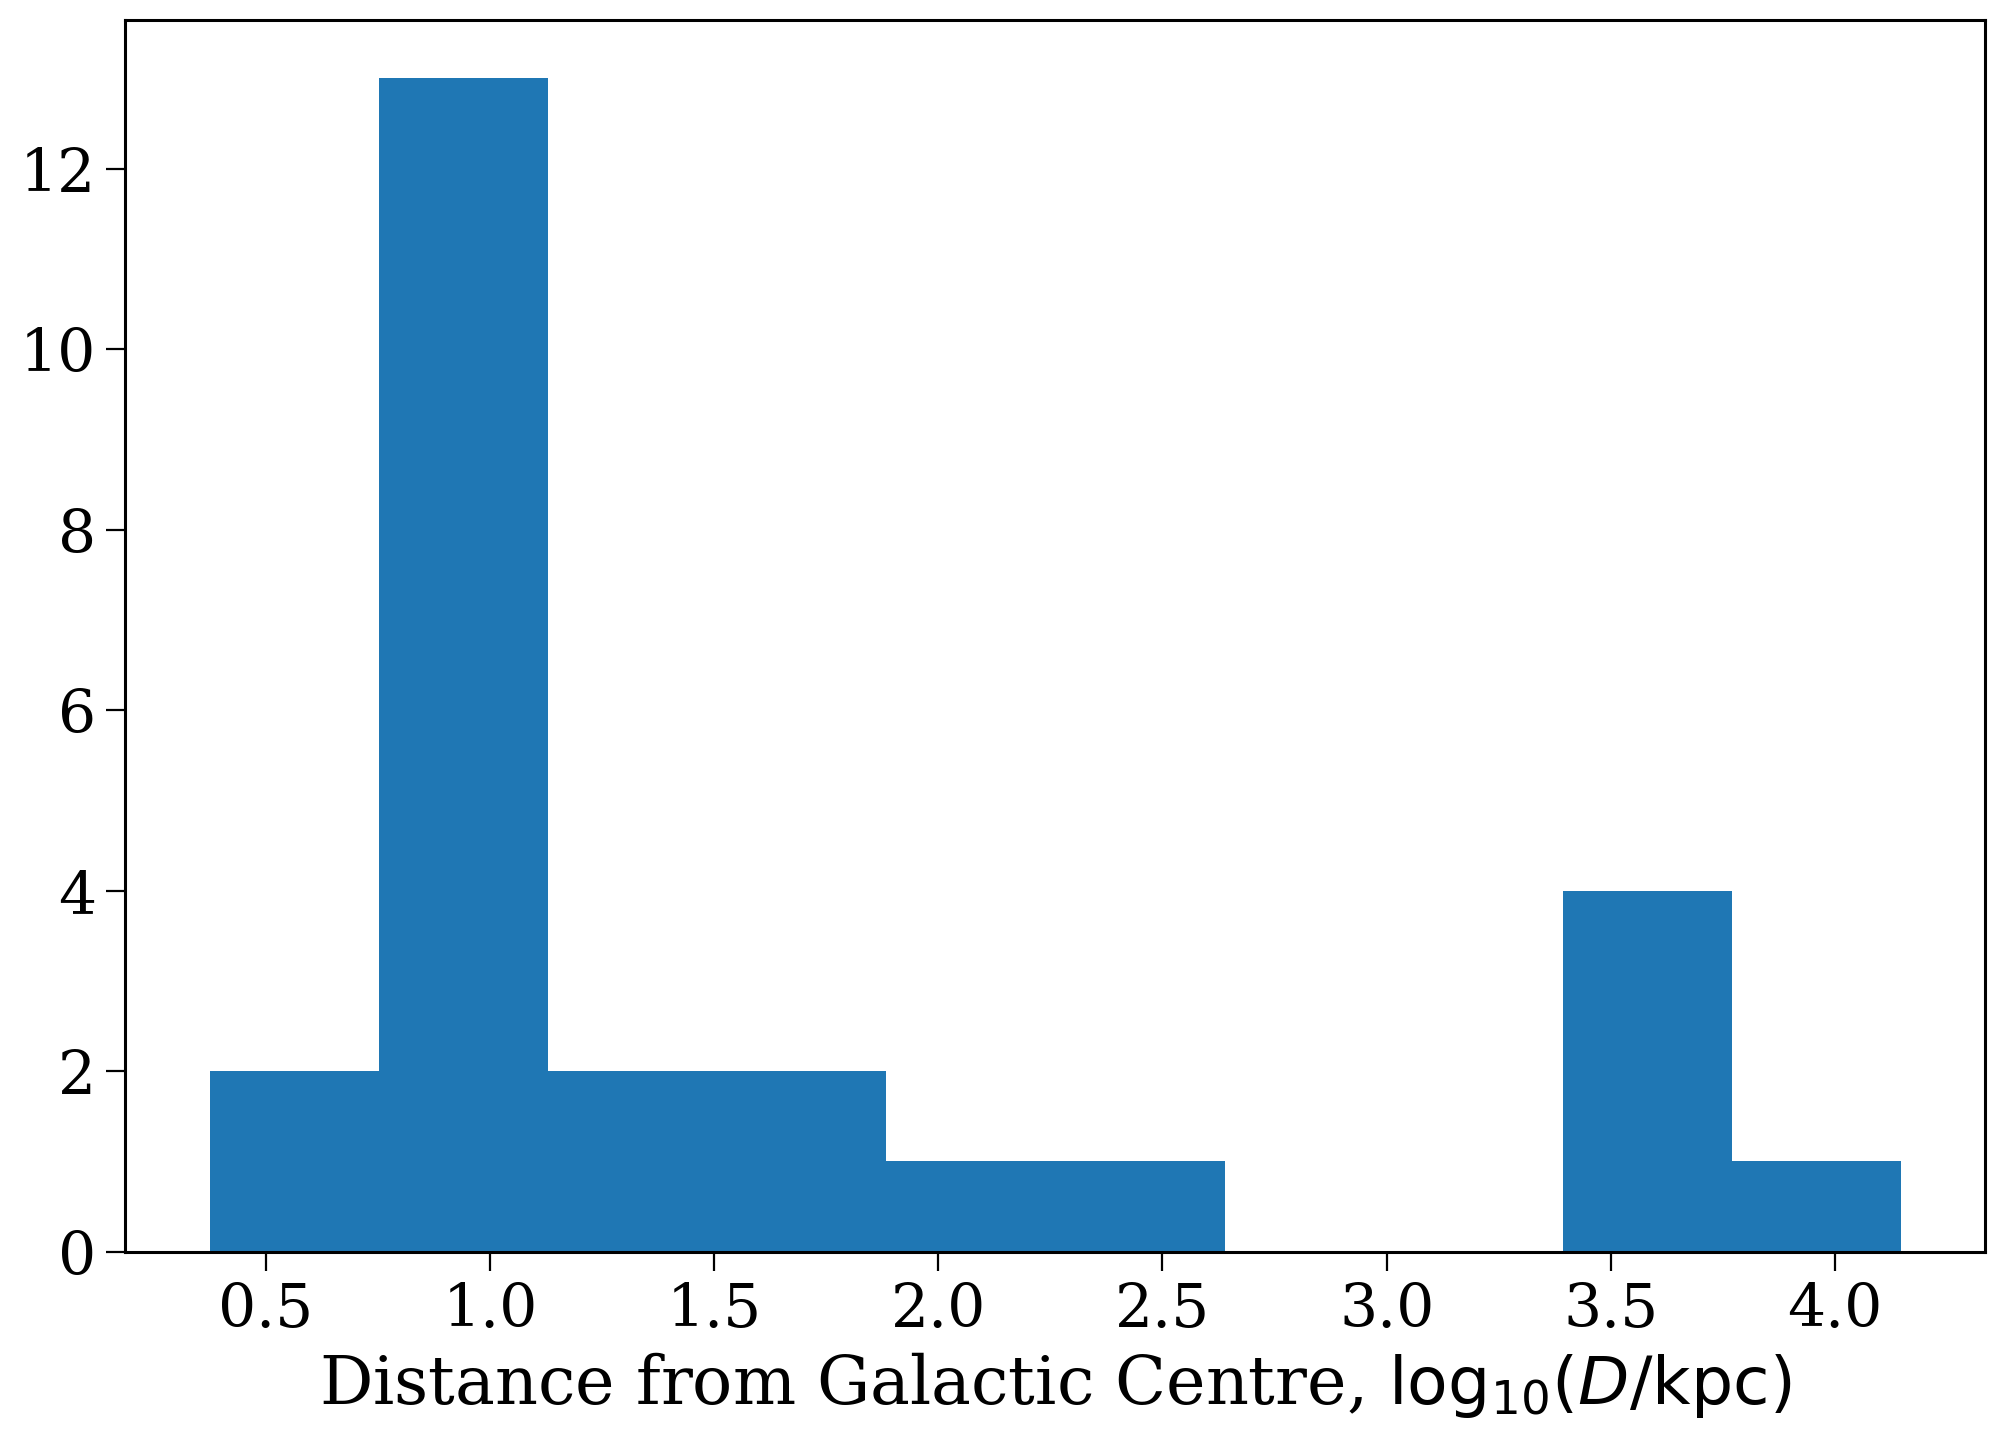

In [127]:
plt.hist(np.log10(dcos.final_coords[0].icrs.distance.to(u.kpc).value))
plt.xlabel(r"Distance from Galactic Centre, $\log_{10}(D/{\rm kpc})$")
plt.show()

## When will they merge?

In [6]:
t_merge = legwork.evol.get_t_merge_ecc(ecc_i=dcos.final_bpp["ecc"].values,
                                       a_i=dcos.final_bpp["sep"].values * u.Rsun,
                                       m_1=dcos.final_bpp["mass_1"].values * u.Msun,
                                       m_2=dcos.final_bpp["mass_1"].values * u.Msun)

## _Where_ will they merge?

I've only considered things merging in the next Tyr which is still probably still too lax.

### For escaped DCOs, just move linearly

In [7]:
def get_escaped(s):
    escaped = [np.repeat(False, len(s)), np.repeat(False, len(s))]
    
    for ind, mask in enumerate([np.repeat(True, len(s)), s.disrupted]):
        pos = np.asarray([s.final_coords[ind][mask].galactocentric.x.to(u.kpc),
                          s.final_coords[ind][mask].galactocentric.y.to(u.kpc),
                          s.final_coords[ind][mask].galactocentric.z.to(u.kpc)]) * u.kpc
        v_curr = np.sum(s.final_coords[ind][mask].velocity.d_xyz**2, axis=0)**(0.5)
        v_esc = np.sqrt(-2 * s.galactic_potential(pos))
        escaped[ind][mask] = v_curr >= v_esc
    return escaped

In [139]:
esc = get_escaped(dcos)[0]
esc_dcos = dcos[dcos.bin_nums[esc]]
gal_dcos = dcos[dcos.bin_nums[~esc]]

In [239]:
future_mergers = np.zeros((len(dcos), 3)) * u.kpc

In [240]:
movement = (esc_dcos.final_coords[0].velocity * t_merge[esc]).d_xyz.to(u.kpc)
future_mergers[esc] = (np.asarray([esc_dcos.final_coords[0].x.to(u.kpc),
                                   esc_dcos.final_coords[0].y.to(u.kpc),
                                   esc_dcos.final_coords[0].z.to(u.kpc)]) * u.kpc + movement).T

### For DCOs still bound to the galaxy, integrate orbits

In [203]:
import gala.integrate as gi

In [242]:
for i, bin_num in enumerate(dcos.bin_nums):
    if not esc[i] and t_merge[i] < 1000 * u.Gyr:
        start_time = dcos.final_bpp.tphys[bin_num] * u.Myr
        print(start_time, t_merge[i])
        final = dcos.galactic_potential.integrate_orbit(dcos.orbits[i][-1], t1=start_time,
                                        t2=start_time + t_merge[i], dt=1 * u.Myr,
                                        store_all=False, Integrator=gi.DOPRI853Integrator)
        print(final.pos.xyz.ravel())
        future_mergers[i] = final.pos.xyz.ravel()

11520.648934129866 Myr 982.8469318282864 Gyr
[  3.36394978 -34.92891323  44.24726904] kpc


In [243]:
future_mergers[t_merge < 1 * u.Tyr]

<Quantity [[ 3.36394978e+00, -3.49289132e+01,  4.42472690e+01],
           [-2.16409708e+05, -2.28822024e+05,  2.40011655e+05]] kpc>

In [245]:
future_merger_distances = np.sum(future_mergers[t_merge < 1 * u.Tyr]**2, axis=1)**(0.5)
future_merger_distances

<Quantity [5.64727010e+01, 3.95977619e+05] kpc>

# Past mergers

In [66]:
merged = p.bpp[p.bpp["sep"] == 0].index.unique()
ever_bhbh = p.bpp[(p.bpp["kstar_1"] == 14) & (p.bpp["kstar_2"] == 14)].index.unique()
bhbh_mergers = p[np.intersect1d(merged, ever_bhbh)]

In [261]:
present_times = bhbh_mergers.final_bpp["tphys"].values * u.Myr
merger_times = bhbh_mergers.bpp[(bhbh_mergers.bpp["kstar_1"] == 14)
                              & (bhbh_mergers.bpp["kstar_2"] == 14)].drop_duplicates(subset="bin_num", keep="last")["tphys"].values * u.Myr

In [265]:
past_mergers = np.zeros((len(bhbh_mergers), 3)) * u.kpc
for i in range(len(bhbh_mergers)):
    past_mergers[i] = bhbh_mergers.galactic_potential.integrate_orbit(bhbh_mergers.orbits[i][-1],
                                                                      t1=present_times[i],
                                                                      t2=merger_times[i], dt=-1 * u.Myr,
                                                                      store_all=False,
                                                                      Integrator=gi.DOPRI853Integrator).pos.xyz.ravel()

In [274]:
past_merger_distances = np.sum(past_mergers**2, axis=1)**(0.5)
past_merger_distances

<Quantity [3.84099714e+01, 1.84357495e+03, 2.93885312e+01, 1.32127646e+02,
           2.33856229e+02, 1.17624753e+02, 5.49021676e+00, 2.23260475e+01,
           1.76880293e+02, 8.41909347e+03, 6.16811951e+02] kpc>

In [273]:
future_merger_distances

<Quantity [5.64727010e+01, 3.95977619e+05] kpc>